# Damped, driven linear oscillator: various cases

The examples shown in this notebook were taken from M. Tabor, Chaos and Integrability in Nonlinear Dynamics, Chap. 1

Here, we consider numerical solutions to ODEs which represent a system subjected to some form of external time-dependent force $F(t)$. Particularly interesting are those cases where $F(t)$ is a periodic function, for example, $F(t) \approx cos(\Omega t)$. Consider as an example the damped, driven linear oscillator

$$
\ddot{x}+\lambda \dot{x}+\omega^2 x = \epsilon F(t)
$$

where $\epsilon$ can be thought of as a 'coupling parameter' --in the limit $\epsilon\rightarrow 0$, the system becomes autonomous again. We can re-write this differential equation as:

$$
\begin{align}
    \begin{split}
        \dot{x}&=y \\
        \dot{y}&=-\lambda y -\omega^2 x + \epsilon \cos(\Omega t) \\
    \end{split}
\end{align}
$$

We will study this system, and consider several distinct cases. We will integrate it using `TaylorIntegration`, and visualize the results using `Plots`:

In [1]:
using TaylorIntegration, Plots
pyplot()

Plots.PyPlotBackend()

Before we start, we fix some integration parameters (the order of Taylor expansions and the local absolute error tolerance):

In [2]:
const abstol = 1e-30
const order = 28

28

## 1. The driven oscillator (non-resonant)

First, we will consider the non-resonant, frictionless, linear oscillator:

$$
\ddot{x}+\omega^2x=\epsilon\cos(\Omega t),
$$
which we will rewrite as:

$$
\begin{align}
\begin{split}
\dot{x}_1 &= x_2 \\
\dot{x}_2 &= -\omega^2x_1+\epsilon\cos(x_3) \\
\dot{x}_3 &= \Omega
\end{split}
\end{align}
$$

This ODE is subject to initial conditions $x(0)=x_0$ and $\dot{x}(0)=v_0$. Here, we have $\lambda=0$ (no friction), and $\omega \neq \Omega$ (non-resonant condition).

In [3]:
const Ω = 1.0 #forcing frequency
const ϵ = 0.5 #forcing amplitude
const ω = 1.1 #"natural" frequency
const T = 2π/ω #period associated to oscillator's ω

#the driven linear oscillator ODE:
function drivenosc!(t, x, dx)
    dx[1] = x[2]
    dx[2] = -(ω^2)*x[1]+ϵ*cos(Ω*t)
    nothing
end

drivenosc! (generic function with 1 method)

The initial time, initial condition and final time are:

In [4]:
const t0 = 0.0 #initial time
const x0 = [1.0,0.0] #initial condition
#const x0 = [1.0,0.0,Ω*t0] #initial condition
const tmax = 100*T # 200*T #final time of integration

571.1986642890532

Then, the particular solution is:

$$
x_\mathrm{part}(t)=\frac{\epsilon}{\omega^2-\Omega^2} \cos(\Omega t)
$$

In [5]:
x_part(t) = ϵ*cos(Ω*t)/(ω^2-Ω^2)

x_part (generic function with 1 method)

The overall solution is:

$$
x_\mathrm{gral}(t) = a\sin(\omega t +\delta)+\frac{\epsilon}{\omega^2-\Omega^2} \cos(\Omega t)
$$

where

$$
\begin{align}
\begin{split}
a &= \sqrt{ \left( x_0-\frac{\epsilon}{\omega^2-\Omega^2}\right)^2+\left( \frac{\dot{x}_0}{\omega} \right)^2 } \\
\delta &= \arctan\left( \frac{ x_0-\frac{\epsilon}{\omega^2-\Omega^2} }{ \dot{x}_0/\omega } \right)
\end{split}
\end{align}
$$

In [6]:
const a = sqrt( (x0[1]-ϵ/(ω^2-Ω^2))^2+(x0[2]^2/ω^2) ) #amplitude
const δ = atan((ω*(x0[1]-ϵ/(ω^2-Ω^2))/x0[2])) #phase shift

x_gral(t) = a*sin(ω*t+δ)+x_part(t)

a, δ

(1.3809523809523787, -1.5707963267948966)

We can check if our expression for `x_gral ` is consistent, using `TaylorSeries`:

In [7]:
t_poly = TaylorSeries.Taylor1([0.0, 1.0], 3) #A Taylor polynomial which represents time
x_gral(t_poly) #evaluate x_gral at t_poly

 1.0 + 9.30148402209536e-17 t - 0.3550000000000001 t² - 1.8757992777892314e-17 t³ + 𝒪(t⁴)

We can get the numerical value of the derivatives of `x_gral` up to any order we want! In particular, its 0-th and 1st order coefficients are consistent, within machine epsilon, with the initial conditions $x_0=1$, $\dot{x}_0=0$.

Now, let's integrate the ODE:

In [8]:
@time tT, xT = taylorinteg(drivenosc!, x0, t0, tmax, order, abstol, maxsteps=50000);

  0.371958 seconds (612.46 k allocations: 56.206 MiB, 4.59% gc time)


In this case, the solution represents the sum of two sinusoidal signals with different frequencies and therefore we can observe the phenomenon of beats:


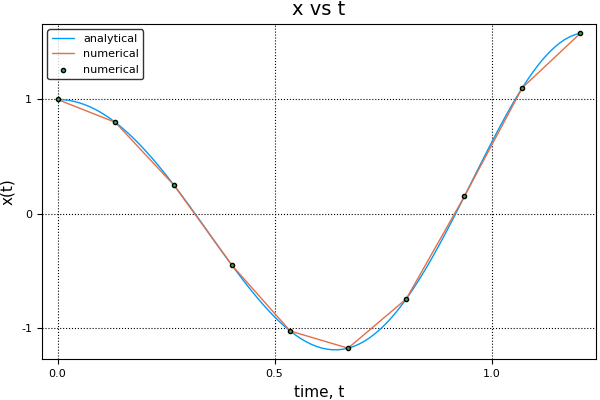

In [9]:
# x vs t, the first steps
firsti =1 # length(tT2)-20
lasti =10 # length(tT2)
myrange=firsti:lasti
lint = linspace(tT[firsti], tT[lasti], 10*length(myrange))
plot(
lint/T,
x_gral.(lint),
xaxis="time, t",
yaxis="x(t)",
title="x vs t",
label="analytical"
#leg=false
)
plot!(
tT[myrange]/T,
xT[myrange,1],
xaxis="time, t",
yaxis="x(t)",
title="x vs t",
label="numerical",
leg=false
)
scatter!(
tT[myrange]/T,
xT[myrange,1],
label="numerical",
leg=true,
ms=3.0
)


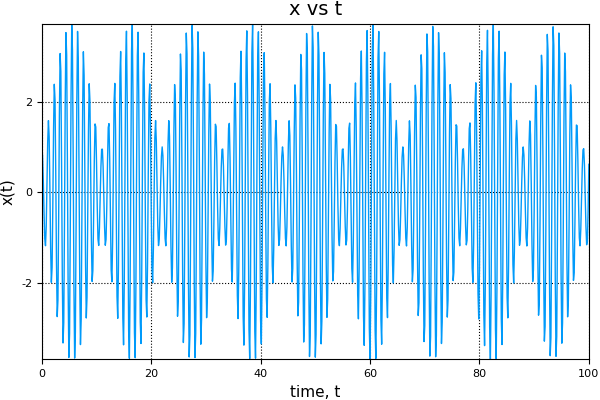

In [10]:
# x vs t
plot(
tT/T,
xT[:,1],
xaxis="time, t",
yaxis="x(t)",
title="x vs t",
leg=false
)

Now, how does the numerical solution compare to the analytical solution? Well, we can measure this via the difference between the analytical solution and the numerical solution at each time step:

$$
\Delta x(t) = x_\mathrm{num}(t)-x_\mathrm{gral}(t)
$$

We measure this in machine epsilons (`eps()`):

In [11]:
#the absolute error in machine epsilons
Δx = (xT[:,1]-x_gral.(tT))/eps()
#absolute error, numerical solution, analytic solution, at last time step:
Δx[end], xT[end,1], x_gral(tT[end])

(945.5, 0.6220322210267172, 0.6220322210265072)

At the end of the integration, the error in the numerical solution is less than 700`eps()`! Now, let's plot the absolute error as a function of time:


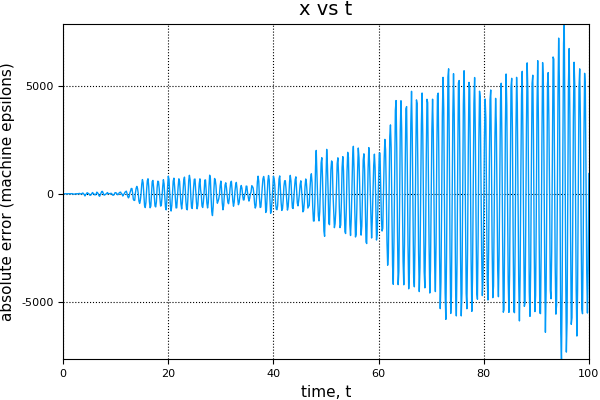

In [12]:
plot(
tT/T,
Δx, #the absolute error in machine epsilons
xaxis="time, t",
yaxis="absolute error (machine epsilons)",
title="x vs t",
leg=false
)

## 2. The driven oscillator: resonance

When $\Omega \rightarrow \omega$, the solution

$$
\begin{align}
x_\mathrm{gral}(t) &= a\sin(\omega t +\delta)+\frac{\epsilon}{\omega^2-\Omega^2} \cos(\Omega t)
\end{align}
$$

given before, breaks down. This condition is an example of resonance. In this case, the ODE we are trying to solve is:

$$
\begin{align}
  \begin{split}
    \dot{x}_1 &= x_2 \\
    \dot{x}_2 &= -\omega^2x_1+\epsilon\cos(\omega t) \\
  \end{split}
\end{align}
$$

and the general solution (for $x_1$) is:

$$
x_\mathrm{gral}(t) = a\sin(\omega t +\delta)+\frac{\epsilon t}{2\omega} \cos(\omega t)
$$

Note that, once we know $x_1$, then $x_2$ can be calculated straightforward; $x_3(t)=\omega t$ by definition. The coefficients $a$ and $\delta$ are given in this case by:

$$
\begin{align}
\begin{split}
a &= \sqrt{x_0^2+\dot{x}_0^2/\omega^2} \\
\delta &= \arctan \left( \frac{\omega x_0}{\dot{x}_0} \right)
\end{split}
\end{align}
$$

In [13]:
#the resonant driven linear oscillator ODE:
function drivenoscres!(t, x, dx)
    dx[1] = x[2]
    dx[2] = -(ω^2)*x[1]+ϵ*cos(ω*t)
    nothing
end

drivenoscres! (generic function with 1 method)

In [14]:
const a′ = sqrt( x0[1]^2+(x0[2]^2/ω^2) ) #amplitude
const δ′ = atan((ω*x0[1]/x0[2])) #phase shift

x_gral_res(t) = a′*sin(ω*t+δ′)+ϵ*t*sin(ω*t)/(2ω) #overall solution with resonance

x_gral_res (generic function with 1 method)

If we want to test the consistency of our expression for `x_gral`, we can do so by evaluating it using `TaylorSeries`:

In [15]:
x_gral_res(TaylorSeries.Taylor1([0.0, 1.0], 3))

 1.0 + 6.735557395310444e-17 t - 0.3550000000000001 t² - 1.3583374080542732e-17 t³ + 𝒪(t⁴)

We're ready to perform a Taylor integration for the resonant driven linear oscillator:

In [16]:
const tmax = 100*T # 200*T

571.1986642890532

In [17]:
@time tT2, xT2 = taylorinteg(drivenoscres!, x0, t0, tmax, order, abstol, maxsteps=50000);

  0.127499 seconds (518.14 k allocations: 54.571 MiB, 22.92% gc time)



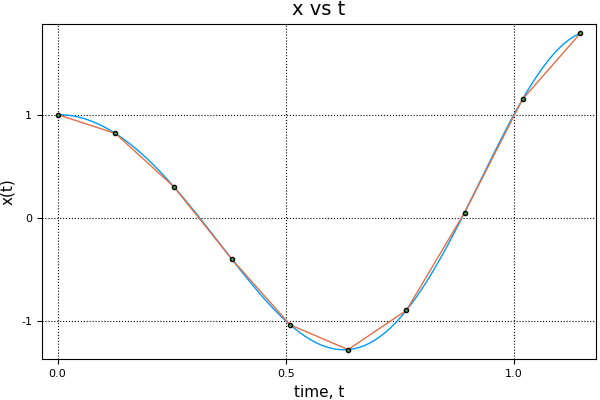

In [18]:
# x vs t, the first steps
firsti2 =1 # length(tT2)-20
lasti2 =10 # length(tT2)
myrange2=firsti2:lasti2
lint2 = linspace(tT2[firsti2], tT2[lasti2], 10*length(myrange2))
plot(
lint2/T,
x_gral_res.(lint2),
xaxis="time, t",
yaxis="x(t)",
title="x vs t",
leg=false
)
plot!(
tT2[myrange2]/T,
xT2[myrange2,1],
xaxis="time, t",
yaxis="x(t)",
title="x vs t",
leg=false,
)
scatter!(
tT2[myrange2]/T,
xT2[myrange2,1],
leg=false,
ms=3.0
)


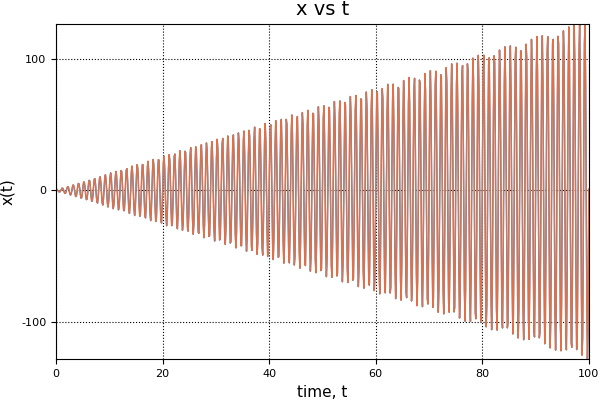

In [19]:
# x vs t
plot(
tT2/T,
xT2[:,1],
xaxis="time, t",
yaxis="x(t)",
title="x vs t",
leg=false
)
plot!(
tT2/T,
x_gral_res.(tT2),
xaxis="time, t",
yaxis="x(t)",
title="x vs t",
leg=false
)

The solution grows unbounded with time! Physically, this means that the external source is imparting energy to the system, and there are no losses of energy due to any damping ($\lambda = 0$).

Once again we ask: how does this numerical solution compare to the analytical solution?

In [20]:
#the absolute error in machine epsilons
Δx2 = (xT2[:,1]-x_gral_res.(tT2))/eps();
Δx2[end], xT2[end,1], x_gral_res(tT2[end])

(237767.0, 1.000000000053305, 1.00000000000051)


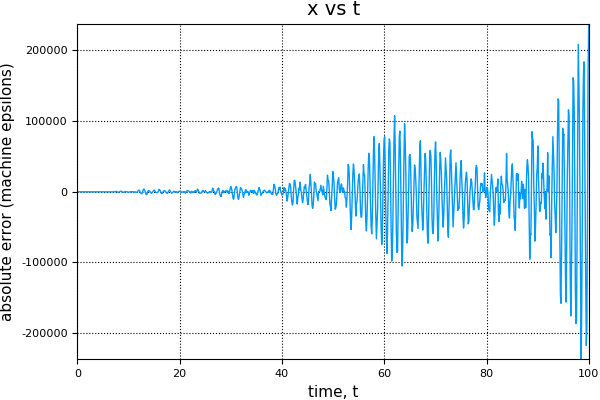

In [21]:
plot(
tT2/T,
Δx2, #the absolute error in machine epsilons
xaxis="time, t",
yaxis="absolute error (machine epsilons)",
title="x vs t",
leg=false
)

Now, try doing longer integrations for the system above. How does the absolute error behave for longer times of integration? Does it grow systematically? Is there a way to know if the error in our integrations is dominated by roundoff errors?

## 3. The damped driven oscillator ($\lambda \neq 0$)

We return to the original problem:

$$
\begin{align}
    \begin{split}
        \dot{x}_1&=x_2 \\
        \dot{x}_2&=-\lambda x_2 -\omega^2 x_1 + \epsilon \cos(\Omega t) \\
    \end{split}
\end{align}
$$

i.e., here $\lambda \neq 0$. In this case, the overall solution may be written as:

$$
x(t) = Ae^{-\lambda t/2}\cos(\nu t + \Delta)+\frac{\epsilon\cos(\Omega t+\Delta_\mathrm{ext})}{\sqrt{(\omega^2-\Omega^2)^2+\lambda^2\Omega^2}}
$$

where the intrinsic frequency $\nu$ is

$$
\nu = \frac{1}{2}\sqrt{4\omega^2-\lambda^2}
$$

and the "external" phase $\Delta_\mathrm{ext}$ is given by

$$
\Delta_\mathrm{ext} = \arctan \left( \frac{ -\lambda\Omega }{ (\omega^2-\Omega^2) } \right)
$$

We actually have three sub-cases,  depending on the value of $4\omega^2-\lambda$:

+ $4\omega^2-\lambda>0$: sub-damping
+ $4\omega^2-\lambda=0$: critical damping
+ $4\omega^2-\lambda<0$: super-damping

Here, we will analyze only the first case, but we only need to change the values of $\omega$ and $\lambda$ and then run the integration again to analyze those other cases too!

The amplitud $A$ and phase $\Delta$ of the homogeneous part are determined by the initial conditions and are given by

$$
\begin{align}
\begin{split}
A &= \sqrt{(A\cos\Delta)^2+(A\sin\Delta)^2} \\
\Delta &= \arctan\left( \frac{A\sin\Delta}{A\cos\Delta} \right)
\end{split}
\end{align}
$$

where 

$$
\begin{align}
\begin{split}
A\sin\Delta &= \frac{1}{\nu}( \frac{\lambda}{2}(\alpha-x_0)-(\dot{x}_0+\beta) ) \\
A\cos\Delta &= x_0-\alpha
\end{split}
\end{align}
$$

and, in turn,

$$
\begin{align}
\begin{split}
\alpha &= \frac{\epsilon\cos(\Delta_\mathrm{ext})}{\sqrt{(\omega^2-\Omega^2)^2+\lambda^2\Omega^2}} \\
\beta &= \frac{\epsilon\Omega\sin(\Delta_\mathrm{ext})}{\sqrt{(\omega^2-\Omega^2)^2+\lambda^2\Omega^2}}
\end{split}
\end{align}
$$

In [22]:
const Ω = 2.0 #forcing frequency
const ϵ = 0.5 #forcing amplitude
const ω = 1.1 #"natural" frequency
const λ = 0.2 #damping

0.2

In [23]:
#the driven, damped linear oscillator ODE:

function drivdamposc!(t, x, dx)
    dx[1] = x[2]
    dx[2] = -λ*x[2]-(ω^2)*x[1]+ϵ*cos(Ω*t)
    nothing
end

drivdamposc! (generic function with 1 method)

In [24]:
#two-variable versions of atan(y/x)
myatan(x, y) = y>=zero(x)?( x>=zero(x)?atan(y/x):(atan(y/x)+pi) ):( x>=zero(x)?(atan(y/x)+2pi):(atan(y/x)+pi) )
myatan2(x, y) = y>=zero(x)?( x>=zero(x)?atan(y/x):(atan(y/x)-pi) ):( x>=zero(x)?(atan(y/x)):(atan(y/x)+pi) )

const t0 = 0.0
const x0 = [5.0,0.0] #initial condition

const ν = 0.5*sqrt(4(ω^2)-λ^2) #the intrinsic frequency
const Text = 2π/Ω #period associated to external frequency Ω
const Δext = myatan2( (ω^2-Ω^2), (-λ*Ω) ) #the "external" phase

#some auxiliary variables... (see text)
const α = ϵ*cos(Δext)/sqrt( (ω^2-Ω^2)^2+(λ^2)*(Ω^2) )
const β = ϵ*Ω*sin(Δext)/sqrt( (ω^2-Ω^2)^2+(λ^2)*(Ω^2) )
const AcosΔ = x0[1]-α
const AsinΔ = ( (λ/2)*(α-x0[1])-(x0[2]+β) )/ν

const A = sqrt( AsinΔ^2+AcosΔ^2 ) #the homogeneous amplitude
#we have to be careful with the homogeneous phase, when inverting tan:
#if atan( AsinΔ./AcosΔ ) < 0
#    const Δ = atan( AsinΔ./AcosΔ )+π #homogeneous phase, case 1
#else
#    const Δ = atan( AsinΔ./AcosΔ ) #homogeneous phase, case 2
#end

const Δ = myatan2( AcosΔ , AsinΔ )

println("A=", A)
println("Δ=", Δ)
println("AcosΔ=", AcosΔ)
println("AsinΔ=", AsinΔ)
println("Δext=", Δext)

A=5

.193145415819222
Δ=-0.08222027678306153
AcosΔ=5.175602019108521
AsinΔ=-0.42650093744798
Δext=3.2839914642983628


In [25]:
#the general solution to the damped driven linear oscillator:
x_ddo(t) = A*exp(-λ*t/2)*cos(ν*t+Δ)+ϵ*cos(Ω*t+Δext)/sqrt( (ω^2-Ω^2)^2+(λ^2)*(Ω^2) )

x_ddo (generic function with 1 method)

Again, we check for consistency of our expression between the analytical solution, `x_ddo`, and the given initial conditions:

In [26]:
x_ddo(TaylorSeries.Taylor1([0.0, 1.0], 3))

 5.0 - 7.632783294297951e-17 t - 2.7750000000000004 t² + 0.18500000000000005 t³ + 𝒪(t⁴)

The final time of integration is:

In [27]:
const tmax = 100*Text

314.1592653589793

We're now ready to integrate:

In [28]:
@time tT3, xT3 = taylorinteg(drivdamposc!, x0, t0, tmax, order, abstol, maxsteps=50000);

  0.170335 seconds (523.14 k allocations: 55.079 MiB, 11.53% gc time)


How does the solution $x(t)$ look like during the first few steps? Let's plot it!


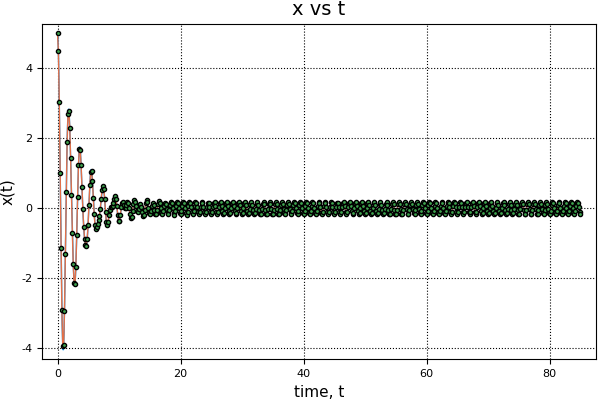

In [29]:
# x vs t, the first firsti3-lasti3 steps, starting from the firsti3-th step

firsti3 = 1 # length(tT3)-200 #1 # length(tT3)-20
lasti3 = 600 # length(tT3) #10 # length(tT3)
myrange3=firsti3:lasti3
lint3 = linspace(tT3[firsti3], tT3[lasti3], 10*length(myrange3))
plot(
lint3/Text,
x_ddo.(lint3),
xaxis="time, t",
yaxis="x(t)",
title="x vs t",
leg=false
)
plot!(
tT3[myrange3]/Text,
xT3[myrange3,1],
xaxis="time, t",
yaxis="x(t)",
title="x vs t",
leg=false,
)
scatter!(
tT3[myrange3]/Text,
xT3[myrange3,1],
leg=false,
ms=3.0
)

As $t$ increases, the homogeneous (exponential) part of the solution decays and one is finally left with

$$
\lim_{t\to\infty} x(t) = \frac{\epsilon\cos(\Omega t+\Delta_\mathrm{ext})}{\sqrt{(\omega^2-\Omega^2)^2+\lambda^2\Omega^2}}
$$

Note that, unlike the case $\lambda=0$, although the amplitude of the motion becomes large at the resonance $\Omega\to\omega$, it does not diverge. Physically, this asymptotic solution corresponds to steady oscillations of constant energy, which represents a balance between the energy pumped to the system and the energy dissipated by friction.

As always, we ask, just how good, quantitatively, is the numerical solution compared to the analytical solution? To answer that (again, as always), we will plot the absolute error as a function of time:

In [30]:
#the absolute error in machine epsilons
Δx3 = (xT3[:,1]-x_ddo.(tT3))/eps();
Δx3[end], xT3[end,1], x_ddo(tT3[end])

(63.75, -0.17560201910850107, -0.17560201910851522)


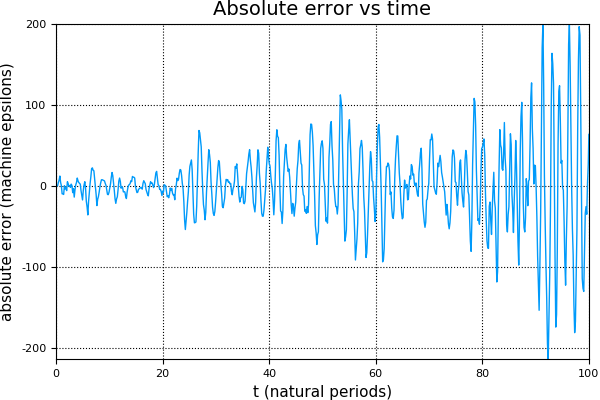

In [31]:
plot(
tT3/Text,
Δx3, #the absolute error in machine epsilons
xaxis="t (natural periods)",
yaxis="absolute error (machine epsilons)",
title="Absolute error vs time",
leg=false
)